# Making Predictions with NBA data

We're now going to make predictive models for regression and classification tasks using Scikit Learn.

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, minimun age of 19 years
- Draft position: A rookie contract value depends on the draft position.
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue.
- Intangibles: For example, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [1]:
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import median_absolute_error, classification_report, confusion_matrix, precision_recall_fscore_support, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
import itertools


# To avoid showing the ConvergenceWarning while running regressors
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
import warnings
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
#warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

import os

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  #drive.flush_and_unmount()

  path = '/content/drive/My Drive/python_estudiando/' 
  import sys
  sys.path.insert(0,path)
else:
  print('Not running on CoLab')
  path = os.getcwd()+"/"

Not running on CoLab


In [5]:
working_df = pd.read_csv(path+"nba_players_processed_dataset.csv", index_col="Unnamed: 0")
working_df.head(2)

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20.00000,134,18.40000,7.20000,5.10000,0.80000,0.40000,0.50000,2711280,"22 years, 11 months, 29 days"
203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12.00000,664,26.80000,9.30000,8.00000,1.50000,0.90000,0.90000,17073171,"29 years, 1 months, 28 days"


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")

In [6]:
data.head(2)

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134,18.40000,7.20000,5.10000,0.80000,0.40000,0.50000,2711280,"23 years, 0 months, 0 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12,664,26.80000,9.30000,8.00000,1.50000,0.90000,0.90000,17073171,"29 years, 1 months, 30 days"


1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

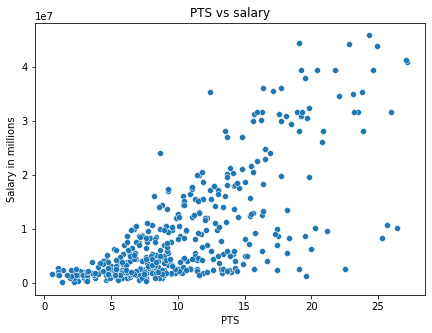

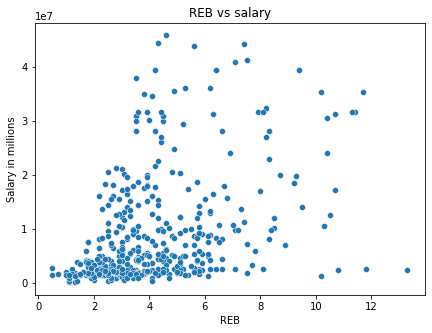

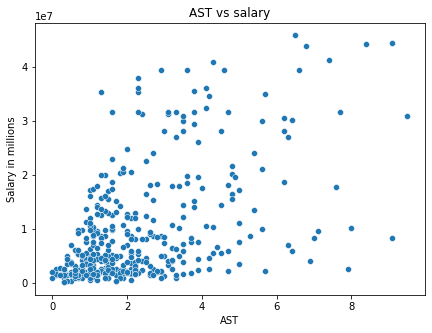

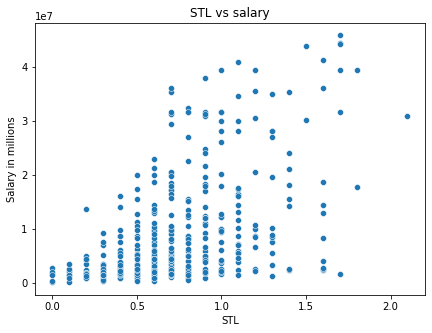

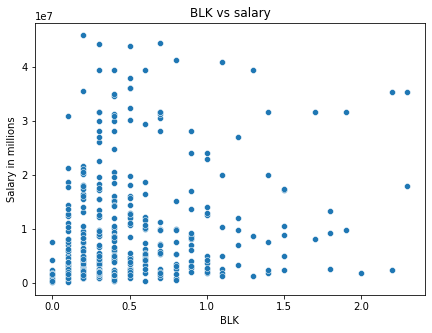

In [ ]:
#fig, ax = plt.subplots(2, 3)
for estadistica in ["PTS", "REB", "AST","STL","BLK"]:
  sns.scatterplot(data=data, x=estadistica, y='SALARY').set(title= f"{estadistica} vs salary", ylabel= "Salary in millions", xlabel= estadistica)
  fig = plt.gcf()
  fig.set_size_inches(7, 5)
  plt.show()

In general, there is a positive correlation between these basic game stats and the salary. It is the most evident in the Points per game case. The only exception may be the Blocks vs Salary relationship.

### Splitting the Dataset

In [ ]:
X = data.drop("SALARY", axis=1)
y = data.SALARY

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, 
                                                           random_state=12,
                                                           shuffle=True
                                                    )

*Don't change anything in this cell, just make it run correctly*

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

Let's create a Baseline model class, that implements fit() and predict() methods. This model will receive a list of all players salaries. It should return a numpy array with the same length but every element should have the same value (the average salary).

In [ ]:
class BaselineModel():
  """
  A baseline model that always returns the same value, the mean of the 
  players salary in the train data
  """
  def __init__(self):
    self.w0 = 0
    self.w1 = 0

  def fit(self, y_train, n_dim):
    """
    Fit the training data. 
    
    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information

    y_test:  Union[pd.Series, np.ndarray]
       a pandas series or numpy array, to get the size of the test dataset
    """
    self.w0 = np.mean(y_train) 
    self.w0 = y_listpred = np.ones(n_dim) * self.w0
  
  def predict(self, X):
    return self.w0
    
    """
    Predict salaries 
    
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
        
    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 
        the mean salary calculated in fit()
    """
      

In [ ]:
model = BaselineModel()
model.fit(y_train, y_test.shape[0])
mean_constant_predictor = model.predict(y_train)

baseline_mae = median_absolute_error(mean_constant_predictor, y_test)
baseline_mae.round(2)

6408963.28

### Regression with a single variable, scoring.

In [ ]:
mm_scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
mm_scaler.fit(X_train['PTS'].values.reshape(-1, 1))

# transform x_train
X_train['PTS'] = mm_scaler.transform(X_train['PTS'].values.reshape(-1, 1))
# transform X_test
X_test['PTS'] = mm_scaler.transform(X_test['PTS'].values.reshape(-1, 1))

linear_model = LinearRegression()
linear_model.fit(X_train[["PTS"]], y_train)
w1 = linear_model.coef_.round(2)
w0 = linear_model.intercept_.round(2)
print(f"pendiente = {w1}, Ordenada = {w0}")

pendiente = [34293421.61], Ordenada = -3644675.19


### Here we plot the linear regressor on the training dataset

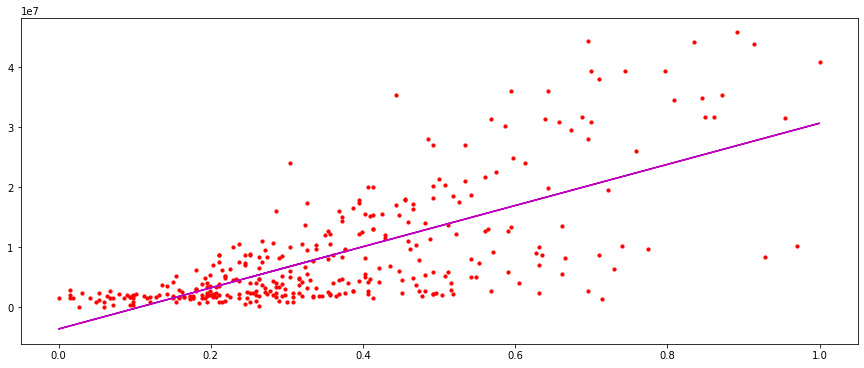

In [ ]:
plt.figure(figsize = (15, 6))
plt.scatter( X_train[["PTS"]], y_train, s=10, c="red")
plt.plot(X_train[["PTS"]], linear_model.predict(X_train[["PTS"]]), label='Regresion Lineal', c='m')

In [ ]:
prediction = linear_model.predict(X_test[["PTS"]])
median_absolute_error(prediction, y_test).round(2)

3621555.18

### [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) using the default parameters.

In [ ]:
sgd_0 = SGDRegressor()
sgd_0.fit(X_train[["PTS"]], y_train)

prediction = sgd_0.predict(X_test[["PTS"]])
default_mae = median_absolute_error(prediction, y_test)
default_mae

3649252.6895293705

1.8. 

Write a function that tries different configurations of hyperparameters: epochs, alpha.

|Theorical concept| symbol | sklearn symbol | Explanation |
|   :---:    |   :---:    |   :---:   |   :---:   |
|Learning rate|  alpha | eta0 | The initial eta rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. Will be updated with different methods depending on 'learning_rate'|
| Regularization | lambda | alpha | Will adjust the strength of the regularization term of the Loss function. Also used to update the eta when learning_rate is set to "optimal". The higher the value, the stronger the regularization. |
| xxx | epochs | max_iter | The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method.|
| xxx | epochs | learning_rate | The learning schedule. ‘constant’, ‘optimal’, ‘invscaling’ or ‘adaptive’ |

The learning rate (eta) in the SGDRegressor sklearn implementation continually updates (except when 'learning_rate' is set to "constant")

             """
              The learning rate schedule:

             ‘constant’: eta = eta0
             ‘optimal’: eta = 1.0 / (alpha * (t + t0)) where t0 is chosen by a heuristic proposed by Leon Bottou.
             ‘invscaling’: eta = eta0 / pow(t, power_t)
             ‘adaptive’: eta = eta0, as long as the training keeps decreasing. 
                          Each time n_iter_no_change consecutive epochs fail to decrease the training loss by tol or fail to increase validation score by tol if early_stopping is True, 
                          the current learning rate is divided by 5.
             """
             loss='squared_error', 
             penalty='l2', 
             



For each combination, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the lowest mean absolute error and print the combination and the MAE.

In [ ]:
# We add some variables to the function so we can use it again on further exercises.

def search_best_hyperparameters(max_iter, eta0, X_train, y_train, X_test, y_test):
  provisional_results = pd.DataFrame(columns=["max_iter", "eta0", "mae"])
  for epochs in max_iter:
    for eta in eta0:
      sgd_0 = SGDRegressor(max_iter = epochs, eta0 = eta)
      sgd_0.fit(X_train, y_train)
      prediction = sgd_0.predict(X_test)
      a = median_absolute_error(prediction, y_test)
      result_0 = {"max_iter": epochs, "eta0": eta, "mae": a}
      provisional_results = provisional_results.append(result_0, ignore_index=True)
  desired_row = provisional_results.loc[provisional_results.mae == provisional_results.mae.min()].reset_index().iloc[0,1:].to_dict()
  result = { "hyperparameters": {"max_iter": desired_row["max_iter"], "eta0": desired_row["eta0"]}, 
             "mae":  desired_row["mae"]
            }
  return result

In [ ]:
max_iter = [1000, 2000, 5000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0, X_train[["PTS"]], y_train, X_test[["PTS"]], y_test)
result

{'hyperparameters': {'max_iter': 2000.0, 'eta0': 0.1},
 'mae': 3488790.105074181}

### Comparing results:

In [ ]:
best_mae = result["mae"]

print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")

Mean Absolute Error for each model:
Baseline: 6408963.279883383
Default SGDRegressor: 3649252.6895293705
Best SGDRegressor: 3488790.105074181


### Multivariable Linear Regression

We'll start with the following variables:

- Points, Rebounds, Assists, Blocks
- Experience, Position, Draft Number

In [ ]:
mv_regression_df = pd.read_csv(path+"nba_players_processed_dataset.csv", index_col = "Unnamed: 0")
mv_regression_df = mv_regression_df[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]]

pd.set_option('display.float_format', lambda x: '%.1f' % x)
mv_regression_df.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,SALARY
0,7.2,5.1,0.8,0.5,2,Forward,20.0,2711280
1,9.3,8.0,1.5,0.9,9,Center,12.0,17073171
2,13.5,8.3,3.5,0.9,5,Center,14.0,28103550
3,4.1,2.7,0.7,0.3,1,Forward,30.0,1994520
4,19.1,8.1,1.9,1.1,16,Center,2.0,2641691


In [ ]:
# 1.11  We do not use draft_lot, but pandas cut instead
def draft_lot(x):
  if x < 16:
    return "firstround_lottery"
  elif x < 31:
    return "firstround_non_lottery"
  elif x < 61:
    return "second_round"
  else:
    # Another way to handle the NaNs, is :
    # if type(x) == None    
    return "undrafted"
mv_regression_df["DRAFT"] = mv_regression_df["DRAFT_NUMBER"].apply(draft_lot) 

#mv_regression_df["DRAFT"] = pd.cut(mv_regression_df["DRAFT_NUMBER"], bins= [0, 15, 30, 60], labels = ["firstround_lottery", "firstround_non_lottery", "second_round"]) 
#mv_regression_df["DRAFT"] = mv_regression_df["DRAFT"].cat.add_categories("undrafted").fillna("undrafted")

mv_regression_df = mv_regression_df.drop("DRAFT_NUMBER", axis=1)

enc = OneHotEncoder(sparse = False, drop='first')
transformed_data = enc.fit_transform(mv_regression_df[["DRAFT"]])

In [ ]:
encoded_data = pd.DataFrame(transformed_data, index=mv_regression_df.index, columns = enc.get_feature_names_out())

In [ ]:
mv_regression_df = pd.concat([mv_regression_df, encoded_data], axis=1)

In [ ]:
mv_regression_df

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,SALARY,DRAFT,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted
0,7.2,5.1,0.8,0.5,2,Forward,2711280,firstround_non_lottery,1.0,0.0,0.0
1,9.3,8.0,1.5,0.9,9,Center,17073171,firstround_lottery,0.0,0.0,0.0
2,13.5,8.3,3.5,0.9,5,Center,28103550,firstround_lottery,0.0,0.0,0.0
3,4.1,2.7,0.7,0.3,1,Forward,1994520,firstround_non_lottery,1.0,0.0,0.0
4,19.1,8.1,1.9,1.1,16,Center,2641691,firstround_lottery,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
495,7.2,3.2,3.0,0.4,7,Guard,8526316,firstround_non_lottery,1.0,0.0,0.0
499,12.8,5.8,1.8,0.4,15,Forward,14190000,firstround_lottery,0.0,0.0,0.0
500,25.3,3.9,9.1,0.2,4,Guard,8326471,firstround_lottery,0.0,0.0,0.0
501,5.3,5.2,0.9,0.4,1,Center,1489065,undrafted,0.0,0.0,1.0


In [ ]:
# 1.11  We do not use draft_lot, but pandas cut instead
def draft_lot(x):
  if x < 16:
    return "firstround_lottery"
  elif x < 31:
    return "firstround_non_lottery"
  elif x < 61:
    return "second_round"
  else:
    # Another way to handle the NaNs, is :
    # if type(x) == None    
    return "undrafted"
mv_regression_df["DRAFT"] = mv_regression_df["DRAFT_NUMBER"].apply(draft_lot) 

#mv_regression_df["DRAFT"] = pd.cut(mv_regression_df["DRAFT_NUMBER"], bins= [0, 15, 30, 60], labels = ["firstround_lottery", "firstround_non_lottery", "second_round"]) 
#mv_regression_df["DRAFT"] = mv_regression_df["DRAFT"].cat.add_categories("undrafted").fillna("undrafted")

mv_regression_df = mv_regression_df.drop("DRAFT_NUMBER", axis=1)

# 1.12
enc = OneHotEncoder(sparse = False)#, drop='first')
transformed_data = enc.fit_transform(mv_regression_df[["DRAFT"]])
encoded_data = pd.DataFrame(transformed_data, index=mv_regression_df.index, columns = enc.get_feature_names_out())
mv_regression_df = pd.concat([mv_regression_df, encoded_data], axis=1)

enc = OneHotEncoder(sparse = False)#, drop='first')
transformed_data = enc.fit_transform(mv_regression_df[["POSITION"]])
encoded_data = pd.DataFrame(transformed_data, index=mv_regression_df.index, columns = enc.get_feature_names_out())
mv_regression_df = pd.concat([mv_regression_df, encoded_data], axis=1)


# 1.13
# At the same time that we separate into features and labels, we drop the already encoded categorical columns.
X = mv_regression_df.drop(["SALARY", "DRAFT", "POSITION"], axis=1)
y = mv_regression_df.SALARY
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,
                                                           random_state=18,
                                                           shuffle=True
                                                    )

# 1.14

cols_to_scale = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train[cols_to_scale])

X_train[cols_to_scale] = mm_scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = mm_scaler.transform(X_test[cols_to_scale])

In [ ]:
#cols_to_scale = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

#mm_scaler = MinMaxScaler()
#mm_scaler.fit(X_train[cols_to_scale].values.reshape(-1, len(cols_to_scale)))

#X_train[cols_to_scale] = mm_scaler.transform(X_train[cols_to_scale].values.reshape(-1, len(cols_to_scale)))
#X_test[cols_to_scale] = mm_scaler.transform(X_test[cols_to_scale].values.reshape(-1, len(cols_to_scale)))

*Don't change anything in this cell, just make it run correctly*

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

We can just use the function from Exercise 1.8

In [ ]:
max_iter = [1000, 2000, 5000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result_multivariable = search_best_hyperparameters(max_iter, eta0, X_train, y_train, X_test, y_test)
best_multivariate_mae_sgd = result_multivariable["mae"]

result_multivariable

{'hyperparameters': {'max_iter': 1000.0, 'eta0': 0.001},
 'mae': 3057982.3670477}

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")
print(f"Best multivariate SGDRegressor: {best_multivariate_mae_sgd}")

Mean Absolute Error for each model:
Baseline: 6408963.279883383
Default SGDRegressor: 3649252.6895293705
Best SGDRegressor: 3488790.105074181
Best multivariate SGDRegressor: 3057132.770064302


1.16. How did the model performed compared to our univariate models? 

Better, lower MAE, 20% better

### DecisionTreeRegressor

Trying different configuration for the following regularization hyperparameters:

- max_depth
- min_samples_leaf
- max_features

In [ ]:
def search_best_hyperparameters(max_depth, min_samples_leaf, max_features, X_train, y_train, X_test, y_test):
  result =  {"max_depth": None, "min_samples_leaf": None,  "max_features":None, "mae": np.Infinity}
  for v1 in max_depth:
    for v2 in min_samples_leaf:
      for v3 in max_features:
        arbol = DecisionTreeRegressor(max_depth = v1, min_samples_leaf = v2, max_features=v3)
        arbol.fit(X_train, y_train)
        prediction = arbol.predict(X_test)

        if mean_absolute_error(prediction, y_test) < result["mae"]:
          result = {"max_depth": v1, "min_samples_leaf": v2,  "max_features":v3, "mae": mean_absolute_error(prediction, y_test)}
  result = { "hyperparameters": {"max_depth": result["max_depth"], "max_features": result["max_features"], "min_samples_leaf": result["min_samples_leaf"]}, 
             "mae":  result["mae"]
            }
  return result

# List of hyperparameter example values
max_depth = [5, 10, 15, 17, 18, 20]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

result_tree = search_best_hyperparameters(max_depth, min_samples_leaf, max_features, X_train, y_train, X_test, y_test)
result_tree

{'hyperparameters': {'max_depth': 18,
  'max_features': 10,
  'min_samples_leaf': 10},
 'mae': 3437870.629058694}

In [ ]:
def search_best_hyperparameters(max_depth, min_samples_leaf, max_features, X_train, y_train, X_test, y_test):
  provisional_results = pd.DataFrame(columns=["max_depth", "min_samples_leaf", "max_features", "mae"])
  for v1 in max_depth:
    for v2 in min_samples_leaf:
      for v3 in max_features:
        arbol = DecisionTreeRegressor(max_depth = v1, min_samples_leaf = v2, max_features=v3)
        arbol.fit(X_train, y_train)
        prediction = arbol.predict(X_test)
        result_0 = {"max_depth": v1, "min_samples_leaf": v2,  "max_features":v3, "mae": median_absolute_error(prediction, y_test)}
        provisional_results = provisional_results.append(result_0, ignore_index=True)
  desired_row = provisional_results.loc[provisional_results.mae == provisional_results.mae.min()].reset_index().iloc[0,1:].to_dict()
  result = { "hyperparameters": {"max_depth": desired_row["max_depth"], "max_features": desired_row["max_features"], "min_samples_leaf": desired_row["min_samples_leaf"]}, 
             "mae":  desired_row["mae"]
            }
  return result

# List of hyperparameter example values
max_depth = [5, 10, 15, 17, 18, 20]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

result_tree = search_best_hyperparameters(max_depth, min_samples_leaf, max_features, X_train, y_train, X_test, y_test)
result_tree

{'hyperparameters': {'max_depth': 18.0,
  'max_features': 10.0,
  'min_samples_leaf': 2.0},
 'mae': 895287.3333333334}

In [ ]:
arbol = DecisionTreeRegressor(max_depth = 18, min_samples_leaf = 2, max_features=10)
arbol.fit(X_train, y_train)

plt.figure(figsize=(12, 10))
plot_tree(arbol, filled=True, feature_names=X_train.columns, class_names= ['0', "1"])
plt.show()

### Comparing :

In [ ]:
best_tree_mae = result_tree["mae"]

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")
print(f"Best multivariate SGDRegressor: {best_multivariate_mae_sgd}")
print(f"Best decision tree Regressor: {best_tree_mae}")

Mean Absolute Error for each model:
Baseline: 6408963.279883383
Default SGDRegressor: 3649252.6895293705
Best SGDRegressor: 3488790.105074181
Best multivariate SGDRegressor: 3057132.770064302
Best decision tree Regressor: 895287.3333333334


The decision tree improved a lot the results, by far the best regressor.

### Analyzing our results

The non linear models worked better, just because the salary is not a linear function of the used features. Restrictions on salary cap, max contracts, rookie contracts or the extension of the contracts (which we dont have info of, a player´s performance may change dramatically for good or bad after a contract of several years of duration is signed).

### Is there something else we could do to improve our results if wanted to make a more accurate model?

Mainly try with more features and hyperparameters. Try also with the L2 metric so predictions that are far away from the reality get more penalized.

Variables "years since last contract was signed", "remaining contract duration" would help in some cases. We dont have info about how many games a players played, or the minutes per game , or the shooting percentages.

## 2. Predicting players All-NBA selections

 This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task.

- You're trying to predict All-NBA selections, which are regular season honours. 
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

We'll use a dataset that contains historical information about players from season starting in 1983 and ending in the 2018-2019 season. The dataset contains statistics for all players, and a target column named "all-nba" : 1 means the player was selected to an All-NBA team that season.

In [ ]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1983_2017_dataset.csv", index_col=0)

Players that played for multiple teams during a season, have "TOT" at the team column.

We may need to map the teams that relocated/changed names. Let´s use the following dictionary.

This wil be particularly useful to use OneHotEncoder in exercises 2.8 and 2.10 .

In [ ]:
all_nba_df.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.5,0.6,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.5,0.8,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.5,0.8,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,...,0.4,0.6,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,...,0.5,0.6,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0


In [ ]:
final_dict = {x:x for x in all_nba_df.team.unique()}
final_dict.update({'NOH':'NOP', 'NOK':'NOP', 'KCK': 'SAC', 'VAN':'MEM', 'SEA': 'OKC', 'NJN': 'BRK', 'WSB': 'WAS', 'SDC': 'LAC', 'CHH':'CHO', 'CHA':'CHO'})

all_nba_df.team = all_nba_df.team.map(final_dict)

In [ ]:
all_nba_df.loc[all_nba_df.player.isin(["Alonzo Mourning", "Kemba Walker"])].iloc[2:-3,:][["season_id", "player", "team"]]

,season_id,player,team
9350,9714,Alonzo Mourning,CHH
9351,9715,Alonzo Mourning,MIA
9352,9716,Alonzo Mourning,MIA
9353,9717,Alonzo Mourning,MIA
9354,9718,Alonzo Mourning,MIA
9355,9719,Alonzo Mourning,MIA
9356,9720,Alonzo Mourning,MIA
9357,9721,Alonzo Mourning,MIA
9358,9722,Alonzo Mourning,NJN
9359,9723,Alonzo Mourning,TOT


In [ ]:
print("Number of rows: ", all_nba_df.shape[0])
print("Number of seasons: ", all_nba_df.season.nunique())
print("Number of unique players: ", all_nba_df.player.nunique())
print("Number of all-nba selections vs non selected: ", all_nba_df.all_nba.sum(),"vs", len(all_nba_df)-all_nba_df.all_nba.sum(), sep="\t")

Number of rows:  14825
Number of seasons:  39
Number of unique players:  2701
Number of all-nba selections vs non selected: 	496	vs	14329


2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'.

**Note:** Assign your features to `X` variable and labels to `y`.



In [ ]:
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
y = all_nba_df['all_nba']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,
                                                           random_state=24,
                                                           shuffle=True, 
                                                           stratify = y
                                                    )

In [ ]:
CLASIFICACION n clases ------- matriz nxn   

(i, j)    en la vida real es "i", pero el modelo predice "j"


BINARIA   2x2

TP = elementos de la clase 1, bien predichos    FP  = no tiene covid, el test dio positivo

FN viceversa                                    TN = elementos de la clase 0, bien predichos 



ejemplo civid, minimizar falsos negativos


500 1s
200000 0s

*Don't change anything in this cell, just make it run correctly*

In [ ]:
if X.shape == (14825, 15) and y.shape == (14825,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')

Success!


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. 

You're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

Accuracy is not the best metric. In this case of a highly imbalanced dataset, we need to go deeper than that.

#### Scaling all numerical features 

In [ ]:
numeric_cols = list(X_train.select_dtypes(include=np.number).columns)
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = mm_scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = mm_scaler.transform(X_test[numeric_cols])

#### Train a LogisticRegression with default parameters, with only the numerical features (we omit the team information for now). This will be our baseline model. 

Evaluate it using accuracy, precision, recall, F1.

In [ ]:
logit = LogisticRegression()
logit.fit(X_train.iloc[:,1:], y_train)
prediction = logit.predict(X_test.iloc[:,1:])

In [ ]:
print(confusion_matrix(y_test, prediction))

[[2859    7]
 [  48   51]]


In [ ]:
# 103 players actually All NBA
# true_negatives                          actual_negatives - true_negatives
# alcual_positives - true_positives       true_positives

# 2859     7
# 48      51

# ACCURACY
print("Accuracy: ", (2852+61)/(2852+42+61+10))

# PRECISION:
# 86% of the All-NBA predictions were actually True.
# 99% of the NON-All-NBA predictions were actually True.
print("Precision: ", 2852/(2852+42), 61/71)

# RECALL
# Out of all the players that actually did NOT get selected All-NBA, the model predicted this outcome correctly for almost all of them.
# Out of all the players selected All-NBA, the model predicted this outcome correctly for almost 59% of them.
print("Recall: ",2852/(2852+10) ,61/(42+61))

# F1 Score: 2*(Precision * Recall) / (Precision + Recall)

# Support:
# How many players belonged to each class in the test dataset.

Accuracy:  0.9824620573355818
Precision:  0.9854872149274361 0.8591549295774648
Recall:  0.9965059399021663 0.5922330097087378


In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2866
           1       0.88      0.52      0.65        99

    accuracy                           0.98      2965
   macro avg       0.93      0.76      0.82      2965
weighted avg       0.98      0.98      0.98      2965



In [ ]:
classification_report(y_test, prediction, output_dict=True)

{'0': {'precision': 0.9834881320949432,
  'recall': 0.9975575715282624,
  'f1-score': 0.9904728910445176,
  'support': 2866},
 '1': {'precision': 0.8793103448275862,
  'recall': 0.5151515151515151,
  'f1-score': 0.6496815286624203,
  'support': 99},
 'accuracy': 0.9814502529510961,
 'macro avg': {'precision': 0.9313992384612647,
  'recall': 0.7563545433398888,
  'f1-score': 0.820077209853469,
  'support': 2965},
 'weighted avg': {'precision': 0.9800096832114802,
  'recall': 0.9814502529510961,
  'f1-score': 0.979094022620967,
  'support': 2965}}

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [ ]:
precision_recall_fscore_support(y_test, prediction)#, pos_label=0, average="binary")

(array([0.98348813, 0.87931034]),
 array([0.99755757, 0.51515152]),
 array([0.99047289, 0.64968153]),
 array([2866,   99]))

In [ ]:
precision_recall_fscore_support(y_test, prediction, pos_label=0, average="binary")

(0.9834881320949432, 0.9975575715282624, 0.9904728910445176, None)

In [ ]:
# Este es el ganador
precision_recall_fscore_support(y_test, prediction, pos_label=1, average="binary")

(0.8793103448275862, 0.5151515151515151, 0.6496815286624203, None)

In [ ]:
# Este es el ganador
precision_recall_fscore_support(y_test, prediction, average="binary")

(0.8793103448275862, 0.5151515151515151, 0.6496815286624203, None)

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [ ]:
# Instantiate the onehotencoder class 
enc = OneHotEncoder(sparse = False)#, drop='first')
enc.fit(X_train[["team"]])

# transform X_train
transformed_data = enc.transform(X_train[["team"]])
encoded_data = pd.DataFrame(transformed_data, index=X_train.index, columns = enc.get_feature_names_out())
X_train = pd.concat([X_train, encoded_data], axis=1).drop(["team", 'team_TOT'], axis=1)

# transform X_test
transformed_data = enc.transform(X_test[["team"]])
encoded_data = pd.DataFrame(transformed_data, index=X_test.index, columns = enc.get_feature_names_out())
X_test = pd.concat([X_test, encoded_data], axis=1).drop(["team", 'team_TOT'], axis=1)

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

    - max_iter=100, Maximum number of iterations taken for the solvers to converge.
    - C=1.0, float, Inverse of regularization strength; must be positive. Like in SVM, smaller values specify stronger regularization.
    - tol=0.0001, float, Tolerance for stopping criteria.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
def search_best_hyperparameters(max_iter, C, tol, X_train, y_train, X_test, y_test):
  # put the lists of hyperparameters into a dict
  hyperparams_ordered_dict = OrderedDict({"max_iter":max_iter, "C":C, "tol":tol})
  desired_metrics = ["precision", "recall", "f1-score"]
  
  # for each tuple of hyperparameters we train the model, predict, and store the results in the DataFrame named "provisional_results".
  result = {"max_iter":0, "C":0, "tol":0, "precision":0, "recall":0, "f1-score":0}
  for element in itertools.product(*hyperparams_ordered_dict.values()):
    result_0 =  {llave:entrada for llave, entrada in zip(hyperparams_ordered_dict.keys(), element)}

    model =  LogisticRegression(max_iter = result_0["max_iter"],  C= result_0["C"], tol = result_0["tol"])
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    metrics_tuple = precision_recall_fscore_support(y_test, prediction, average="binary")[:3]
    #(0.8793103448275862, 0.5151515151515151, 0.6496815286624203)

    for a,b in zip(desired_metrics, metrics_tuple):
      result_0[a] = b
    
    if result_0["f1-score"] > result["f1-score"]:
      result = result_0

  return result
  #return provisional_results

max_iter = [50, 100,150, 200]              # Maximum number of iterations taken for the solvers to converge.
C = [5.0, 1.0, 0.1, 0.05]                   # Inverse of regularization strength; must be positive. Like in SVM, smaller values specify stronger regularization.
                                            # I got the warnings when putting C too small C = 0.01
tol = [0.0001, 0.0003, 0.0006, 0.001 ]     # Tolerance for stopping criteria

result_logit = search_best_hyperparameters(max_iter, C, tol, X_train, y_train, X_test, y_test)
best_logit = LogisticRegression(max_iter = result_logit["max_iter"],  C= result_logit["C"], tol = result_logit["tol"])

result_logit

{'max_iter': 50,
 'C': 5.0,
 'tol': 0.0001,
 'precision': 0.8333333333333334,
 'recall': 0.6060606060606061,
 'f1-score': 0.7017543859649124}

We store and train the best logisitc regressor.

In [ ]:
best_logit =  LogisticRegression(max_iter = result_logit["max_iter"],  C= result_logit["C"], tol = result_logit["tol"])
best_logit.fit(X_train, y_train)

LogisticRegression(C=5.0, max_iter=50)

In [ ]:
#def search_best_hyperparameters(max_iter, C, tol, X_train, y_train, X_test, y_test):
  # put the lists of hyperparameters into a dict
  hyperparams_ordered_dict = OrderedDict({"max_iter":max_iter, "C":C, "tol":tol})

  desired_metrics = ["precision", "recall", "f1-score"]

  # name of the columns with metrics
  metricas_names_list = [f"{x[0]}-{x[1]}" for x in itertools.product(*(y_train.unique(), desired_metrics))]
  
  # generate DataFrame, columns named after hyperparameters and metrics
  provisional_results = pd.DataFrame(columns = list(hyperparams_ordered_dict.keys()) + metricas_names_list)
  
  # for each tuple of hyperparameters we train the model, predict, and store the results in the DataFrame named "provisional_results".
  for element in itertools.product(*hyperparams_ordered_dict.values()):
    result_0 =  {llave:entrada for llave, entrada in zip(hyperparams_ordered_dict.keys(), element)}
    model =  LogisticRegression(max_iter = result_0["max_iter"],  C= result_0["C"], tol = result_0["tol"])

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    metrics_dict = classification_report(y_test, prediction, output_dict=True)
    
    for x in itertools.product(*(y_train.unique(), desired_metrics)):
      result_0[f"{x[0]}-{x[1]}"] = metrics_dict[str(x[0])][x[1]]

    provisional_results = provisional_results.append(result_0, ignore_index=True)

  # select row with best score
  desired_dict = provisional_results.loc[provisional_results["1-f1-score"] == provisional_results["1-f1-score"].max()].reset_index().iloc[0,1:].to_dict()
  desired_dict["hyperparameters"] = {columna: desired_dict[columna] for columna in list(hyperparams_ordered_dict.keys()) }
  for columna in list(hyperparams_ordered_dict.keys()):
    del desired_dict[columna]
  return desired_dict
  #return provisional_results

max_iter = [50, 100,150, 200]              # Maximum number of iterations taken for the solvers to converge.
C = [5.0, 1.0, 0.1, 0.01]                   # Inverse of regularization strength; must be positive. Like in SVM, smaller values specify stronger regularization.
tol = [0.0001, 0.0003, 0.0006, 0.001 ]     # Tolerance for stopping criteria

#result_logit_2 = search_best_hyperparameters(max_iter, C, tol, X_train, y_train, X_test, y_test)

I got the following warning while iterating.

In [ ]:
"""

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 
UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 
Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

"""

Now we evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning.

Load the datasets into 2 dataframes.

In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

The 2 dataframes have the same index and number of rows.

In [ ]:
(all_nba_2018_df.index==all_nba_2018_selections.index).sum() == len(all_nba_2018_df), len(all_nba_2018_df) == len(all_nba_2018_selections)

(True, True)

We want to scale the numerical features. 
From Exercise 2.5, we have the variable ***numeric_cols*** thas has the numeric columns(before encoding the TEAM column) of the dataset uset to train the models. This columns appear on ***all_nba_2018_df*** but on a different order.   

In [ ]:
set(numeric_cols).issubset(set(all_nba_2018_df.columns))

True

In [ ]:
set(all_nba_2018_df.columns) - set(numeric_cols)

{'player',
 'player_id',
 'player_season',
 'season',
 'season_id',
 'season_start',
 'team'}

With the exception of "team" (that we will encode), those remaining features won´t be used. 

For the numeric features, we must use the same MinMax scaler we used to train the model, also from Exercise 2.5

In [ ]:
backup_2018 =  all_nba_2018_df[['season_id', 'player_id', 'player_season', 'player', 'season','season_start' ]]

all_nba_2018_df = all_nba_2018_df[numeric_cols + ["team"]]
all_nba_2018_df[numeric_cols] = mm_scaler.transform(all_nba_2018_df[numeric_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Now we bring up the encoder from Exercise 2.8 to OneHotEncode "team". Remember that on Exercise 2.1 we have already dealt with the discrepancy in the number of teams for the datasets.

In [ ]:
# transform all_nba_2018_df with enc from Exercise 2.8
transformed_data = enc.transform(all_nba_2018_df[["team"]])
encoded_data = pd.DataFrame(transformed_data, index = all_nba_2018_df.index, columns = enc.get_feature_names_out())
all_nba_2018_df = pd.concat([all_nba_2018_df, encoded_data], axis=1).drop(["team", 'team_TOT'], axis=1)

In [ ]:
if all_nba_2018_df.shape == (530, 44): # I have 44 columns instead of 54 because I worked with 30/31 teams from the beginning.
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [ ]:
prediction = best_logit.predict(all_nba_2018_df)

classification_report(all_nba_2018_selections[["all_nba"]], prediction,output_dict=True)["1"]

{'precision': 0.6521739130434783,
 'recall': 1.0,
 'f1-score': 0.7894736842105263,
 'support': 15}

2.12. Analyze the results, what do you think it is happening?

In [ ]:
print(confusion_matrix(all_nba_2018_selections[["all_nba"]], prediction, normalize = "all"))

[[0.95660377 0.01509434]
 [0.         0.02830189]]


In [ ]:
print(confusion_matrix(all_nba_2018_selections[["all_nba"]], prediction))

[[507   8]
 [  0  15]]


The dataset is naturally imbalanced, less than 3% of players have been selected All-NBA. That is why we don´t use accuracy in the first place.

We are showing the specific metrics for the sub-population of All-NBA players, the one with the far less samples, and the most important to work on given the imbalance on the whole dataset and what we are trying to predict.

We have no false negatives, each All-NBA player has been rightly predicted. So the recall is 1.

With the exception of 8 false positives, the model works just fine. But at the same time, since there are only 15 real positives, the precision is of only 65%.

The F1 of 79% shows exactly that balance between the not-so-great precision, and the perfect recall.





----

# Creating our custom Classifier

----

Each year, exactly 15 players are selected to the All-NBA teams. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba.

In [ ]:
all_nba_2018_selections["all_nba_probability"] = best_logit.predict_proba(all_nba_2018_df)[:,1]

In [ ]:
threshold_proba = all_nba_2018_selections.loc[all_nba_2018_selections.all_nba == 1].all_nba_probability.min()

print("The 15 selections appear among the top {} probabilities.".format(len(all_nba_2018_selections.loc[all_nba_2018_selections.all_nba_probability >= threshold_proba])))

all_nba_2018_selections.sort_values("all_nba_probability", ascending=False).loc[all_nba_2018_selections.all_nba_probability >= threshold_proba]

The 15 selections appear among the top 21 probabilities.


,player_id,player,all_nba,all_nba_probability
5604,1024,James Harden,1,1.0
453,83,Giannis Antetokounmpo,1,1.0
6857,1240,LeBron James,1,1.0
14479,2648,Russell Westbrook,1,1.0
3401,587,Anthony Davis,0,0.9
4145,740,Joel Embiid,1,0.9
4895,884,Paul George,1,0.9
3908,695,Kevin Durant,1,0.9
14027,2572,Nikola Vucevic,0,0.9
168,30,LaMarcus Aldridge,0,0.8


2.15

Players actually selected from the all_nba_2018_selections dataset

In [ ]:
all_nba_2018_selections.loc[all_nba_2018_selections.all_nba == 1]

,player_id,player,all_nba,all_nba_probability
453,83,Giannis Antetokounmpo,1,1.0
3168,570,Stephen Curry,1,0.7
3908,695,Kevin Durant,1,0.9
4145,740,Joel Embiid,1,0.9
4895,884,Paul George,1,0.9
5016,909,Rudy Gobert,1,0.7
5399,979,Blake Griffin,1,0.8
5604,1024,James Harden,1,1.0
6634,1204,Kyrie Irving,1,0.5
6857,1240,LeBron James,1,1.0


Players actually selected missing from OUR predictions:

In [ ]:
all_nba_2018_selections.sort_values("all_nba_probability")[:-15].loc[all_nba_2018_selections.all_nba == 1]

,player_id,player,all_nba,all_nba_probability
6634,1204,Kyrie Irving,1,0.5
7225,1315,Nikola Jokic,1,0.6
3168,570,Stephen Curry,1,0.7
14132,2585,Kemba Walker,1,0.7
8103,1492,Kawhi Leonard,1,0.7


Players in our predictions not selected 

In [ ]:
all_nba_2018_selections.sort_values("all_nba_probability", ascending=False)[:15].loc[all_nba_2018_selections.all_nba==0]

,player_id,player,all_nba,all_nba_probability
3401,587,Anthony Davis,0,0.9
14027,2572,Nikola Vucevic,0,0.9
168,30,LaMarcus Aldridge,0,0.8
3794,682,Andre Drummond,0,0.8
3538,633,DeMar DeRozan,0,0.7


Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [ ]:
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor
    
    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    
    all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1983_2017_dataset.csv", index_col=0)
    final_dict = {x:x for x in all_nba_df.team.unique()}
    final_dict.update({'NOH':'NOP', 'NOK':'NOP', 'KCK': 'SAC', 'VAN':'MEM', 'SEA': 'OKC', 'NJN': 'BRK', 'WSB': 'WAS', 'SDC': 'LAC', 'CHH':'CHO', 'CHA':'CHO'})
    all_nba_df.team = all_nba_df.team.map(final_dict)

    X = all_nba_df[["team", 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
    y = all_nba_df['all_nba']
    X_train, _, y_train,_ = train_test_split( X, y, test_size=0.2, random_state=24, shuffle=True, stratify = y)

    # Scaling numerical features in the dataset
    self.numeric_cols = list(X.columns)[1:]
    self.mm_scaler = MinMaxScaler()
    self.mm_scaler.fit(X_train[self.numeric_cols])
    X_train[self.numeric_cols] = self.mm_scaler.transform(X_train[self.numeric_cols])
    
    # One hot encode the Team feature, drop original column.
    self.onehot = OneHotEncoder(sparse = False)
    self.onehot.fit(X_train[["team"]])

    # transform X_train
    transformed_data = self.onehot.transform(X_train[["team"]])
    encoded_data = pd.DataFrame(transformed_data, index=X_train.index, columns = self.onehot.get_feature_names_out())
    X_train = pd.concat([X_train, encoded_data], axis=1).drop(["team", 'team_TOT'], axis=1)

    self.model = model
    self.model.fit(X_train, y_train)

      
  def predict(self, df):
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15
    
    Parameters
    ----------
    df_0 : pd.DataFrame
      a dataframe with the players data
        
    Returns
    -------
    np.ndarray
      An array of the same length as y, with 15 true results based on the players with most probabilities of
      beign selected
    """
    df_0 = df[self.numeric_cols + ["team"]]
    df_0[self.numeric_cols] = self.mm_scaler.transform(df_0[self.numeric_cols])
    
    transformed_data = self.onehot.transform(df_0[["team"]])
    encoded_data = pd.DataFrame(transformed_data, index= df_0.index, columns = self.onehot.get_feature_names_out())
    df_0 = pd.concat([df_0[self.numeric_cols], encoded_data], axis=1).drop(['team_TOT'], axis=1)

    df["all_nba_probability"] = self.model.predict_proba(df_0)[:,1]
    

    return df.sort_values("all_nba_probability", ascending=False)[:15]["player"].values.tolist()

In [ ]:
ejemplo = AllNbaSingleSeasonClassifier(best_logit)

all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)

ejemplo.predict(all_nba_2018_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


['James Harden',
 'Giannis Antetokounmpo',
 'LeBron James',
 'Russell Westbrook',
 'Anthony Davis',
 'Joel Embiid',
 'Paul George',
 'Kevin Durant',
 'Nikola Vucevic',
 'LaMarcus Aldridge',
 'Blake Griffin',
 'Damian Lillard',
 'Andre Drummond',
 'DeMar DeRozan',
 'Rudy Gobert']

In [ ]:
DecisionTreeClassifier,
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)[["player", "all_nba"]]

models_list = [best_logit, LogisticRegression(), DecisionTreeClassifier()]

for predictor in models_list:
  clase = AllNbaSingleSeasonClassifier(predictor)
  prediction_list = clase.predict(all_nba_2018_df)

  def h(player):
    if player in prediction_list:
      return 1
    else:
      return 0

  all_nba_2018_selections["predicted_all_nba"] = all_nba_2018_selections.player.apply(h)
  
  print("\n","-"*30, "\n", predictor, "\n")
  print(classification_report(all_nba_2018_selections[["all_nba"]], all_nba_2018_selections["predicted_all_nba"],output_dict=True)["1"], "\n")
  print(f"Predicted All NBA: {prediction_list[:5]}\n{prediction_list[5:10]}\n{prediction_list[5:10]}\n", "-"*30, "\n")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)



 ------------------------------ 
 LogisticRegression(C=5.0, max_iter=50) 

{'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 15} 

Predicted All NBA: ['James Harden', 'Giannis Antetokounmpo', 'LeBron James', 'Russell Westbrook', 'Anthony Davis']
['Joel Embiid', 'Paul George', 'Kevin Durant', 'Nikola Vucevic', 'LaMarcus Aldridge']
['Joel Embiid', 'Paul George', 'Kevin Durant', 'Nikola Vucevic', 'LaMarcus Aldridge']
 ------------------------------ 



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)



 ------------------------------ 
 LogisticRegression() 

{'precision': 0.6, 'recall': 0.6, 'f1-score': 0.6, 'support': 15} 

Predicted All NBA: ['James Harden', 'Giannis Antetokounmpo', 'LeBron James', 'Russell Westbrook', 'Paul George']
['Joel Embiid', 'Anthony Davis', 'Kevin Durant', 'Nikola Vucevic', 'Karl-Anthony Towns']
['Joel Embiid', 'Anthony Davis', 'Kevin Durant', 'Nikola Vucevic', 'Karl-Anthony Towns']
 ------------------------------ 


 ------------------------------ 
 DecisionTreeClassifier() 

{'precision': 0.26666666666666666, 'recall': 0.26666666666666666, 'f1-score': 0.26666666666666666, 'support': 15} 

Predicted All NBA: ['Luka Doncic', 'Jrue Holiday', 'Kawhi Leonard', 'Kemba Walker', 'Damian Lillard']
['Bradley Beal', 'Danilo Gallinari', 'Jordan Clarkson', 'Domantas Sabonis', 'Hassan Whiteside']
['Bradley Beal', 'Danilo Gallinari', 'Jordan Clarkson', 'Domantas Sabonis', 'Hassan Whiteside']
 ------------------------------ 



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


The main problem with this dataset was the unbalance. 

And the biggest mistake we made was NOT to include the season/year variable, since there is a fixed number of selections per season.

It is a highly unbalanced (whith respect to what we are trying to predict). It was correct to use classification models of course. 

We could have done a more broad hyperparameter tunning, or try with more kinds of classifiers.

Prioritizing the F1-score was good.

For a personal knowledge of the data we are dealing with:

  - we did not use the feature "season" (or year) to train-predict. That is huge since there are only 15 selections per season. So a player´s stats may be good enough in one season, but not in another. 
  
  - Frequent change rules in the NBA in favor of the offensive game over the years may generate an inflation on the raw stats, for example in points and assists. Another reason to use the season feature.

  - nowadays the 3pt shooting is more important than ever. But if we did not take the years into account, there is noise. A good 3pt% in the 80s (without info about the number of 3s taken) may hurt our prediction.

  - the ammount of shots taken per game may make a influence (I think we could actually reconstruct this as a linear combination of the points and shooting stast), but maybe it could have been included. 

  - maybe the goal was to only use individual stats, but team success usually influences All-NBA selections (at least take the win-loss record)

  - we also didnt use the player positions into account. For example, each year there can only be 3 centers selected to the All-NBA teams.

  - Also, until the season 1987-88 there were only 10 players selected (instead of 15), and we took data from that period ( https://en.wikipedia.org/wiki/All-NBA_Team ).

  - There have been a couple of lockouts seasons (1998-99, 2011-12) with less games played per team, which adds noise to the "games" column.



We could maybe include better features, include some team stats, include season/year, the position of the players, the number of shots taken. Also include team stats (win% at least). Also try including the age or season_experience of the player (players too young/old may not be selected).

Mainly also doing a deeper hyperparameter tunning of the models selected. 

Get from NBA api team stats, mainly the win-loss record during the regular season. Team success usually impacts the All-NBA selections.